In [1]:
import os 
import sys
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import functools
import seaborn as sns
import time 

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sys.path.append("../src")
# from load import *
# from util import * 
# from pegasos import *

%matplotlib inline


In [2]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (13,10)

# Problem 2

The kernel matrix is given by $K = XX^T \in \mathbf{R}^{n\times n}$. Explicitly in terms of training vectors it's given by 

$$ K = 
\begin{bmatrix}
x_1^Tx_1 & x_1^Tx_2 & \cdots & x_1^Tx_n\\
x_2^Tx_1 & x_2^Tx_2 & \cdots & x_2^Tx_n\\
\vdots & \vdots & \ddots & \vdots\\
x_n^Tx_1 & x_n^Tx_2 & \cdots & x_n^Tx_n^T
\end{bmatrix}
$$

The squared Euclidean distance between two vectors is given by $d(x,y) = ||x_i-x_j||^2 = ||x_i||^2 + ||x_j||^2 - 2x_i^Tx_j$. It's clear the Gram matrix contains all the information needed to compute the pairwise distances between training examples.

# Problem 3

Consider the regularized least squares objective

$$J(w) = ||Xw-y||^2+ \lambda ||w||^2$$
where $\lambda > 0$

This problem can be written as an ordinary least squres problem of the form $\min ||Aw - b||^2$ where 

$$ 
A = \begin{bmatrix}
X\\
\sqrt{\lambda} I
\end{bmatrix},
b=
\begin{bmatrix}
y \\
0
\end{bmatrix}
$$

This is easily solved as 
$$
\begin{align*}
w^\star &= (A^TA)^{-1}A^Tb\\
&= \left(\begin{bmatrix}
X\\
\sqrt{\lambda} I
\end{bmatrix}^T
\begin{bmatrix}
X\\
\sqrt{\lambda} I
\end{bmatrix}\right)^{-1}
\begin{bmatrix}
X\\
\sqrt{\lambda} I
\end{bmatrix}^T
\begin{bmatrix}
y \\
0
\end{bmatrix}\\
&=(X^TX + \lambda I)^{-1}X^Ty
\end{align*}
$$

The normal equations for the regularized least squares problem is

$$
\begin{align*}
(X^TX + \lambda I)w^\star &= X^Ty\\
w^\star &= \frac{1}{\lambda} (X^Ty - X^TXw^\star)\\
w^\star &= \frac{1}{\lambda} X^T(y - Xw^\star)\\
         &= X^T\alpha\qquad                //\ \alpha := \frac{1}{\lambda} (y - Xw)
\end{align*}
$$

It is evident that the optimal weight vector $w^\star$ is in the span of the data since by the above it is given as a linear combination of the training vectors

$$w^\star = \sum_{i=1}^n \alpha_i x_i$$

The value of the weight vector is 
$$
\begin{align*}
\alpha &= 1/\lambda(y - Xw^\star)\\
\alpha &= 1/\lambda(y - XX^T\alpha)\\
\lambda \alpha &= y - XX^T\alpha\\
(XX^T + \lambda I)\alpha &= y\\
\alpha &= (XX^T + \lambda I)^{-1}y
\end{align*}
$$

The prediction of kernelized ridge regression on the training data is given by

$$
\begin{align*}
\hat{y} &= Xw^\star\\
&= X(X^T\alpha)\\
&= XX^T(XX^T + \lambda I)^{-1}y\\
&= K(K + \lambda I)^{-1}y
\end{align*}
$$

For the prediction of a new training example we have 
$$
\begin{align*}
f(x) &= x^Tw^\star\\
&= \sum_{i=1}^n \alpha_i x^Tx_i\\
&= \sum_{i=1}^n \alpha_i k(x, x_i)\\
&= \alpha^T k_x\\
\end{align*}
$$

# Problem 4

The loss function the SVM is given by 
$$J(w) = \frac{\lambda}{2} ||w||^2 + \frac{1}{n}\sum_{i=1}^n \ell_i(w)$$
Define $J_i(w) = \frac{\lambda}{2} ||w||^2 + \ell_i(w)$

Defining $g_i(w) \in \partial J_i(w)$ and $v_i(w) \in \partial \ell_i(w)$ by taking a subgradient of $J_i(w)$ we have $\lambda w + v_i(w) \in \partial J_i(w)$

The expected value of a subgradient of $J_i(w)$ is

\begin{align*}
    \mathbf{E}[g_i(w)] &= \sum_{i=1}^N p(i)g_i(w)\\
    &= \frac{1}{N}\sum_{i=1}^N g_i(w)\\
    &\in \partial J(w)
\end{align*}

Initializing the Pegasos algorithm with $w^{(1)} = 0$ in the $t$th step we have $w^{(t + 1)} = w^{(t)} - \eta^{(t)}g_i(w^{(t)})$. We also denote $v^{(t)} = v_i(w^{(t)})$ and want to prove the update rule $w^{(t+1)} = - \frac{1}{\lambda t} \sum_{\tau=1}^t v^{(\tau)}$

Computing $w^{(2)}$ we have 
$$
\begin{align*}
    w^{(2)} &= w^{(1)} - \eta^{(t)} g_i(w^{(1)})\\
    &= -\frac{1}{\lambda t} v_i(w^{(1)})\\
    &= -\frac{1}{\lambda t} v^{(1)}\\
\end{align*}
$$
 
This shows that the rule holds for $t=2$. Now suppose it holds for all $t$ up to $t+1$ then 

$$
\begin{align*}
    w^{(t+1)} &= w^{(t)} - \eta^{(t)} g_i(w^{(t)})\\
            &= w^{(t)} - \frac{1}{\lambda t} g_i(w^{(t)})\\
            &= w^{(t)} - \frac{1}{\lambda t} (\lambda w^{(t)} + v_i(w^{(t)}))\\
            &= \left(\frac{t-1}{t}\right) w^{(t)} - \frac{1}{\lambda t}v_i(w^{(t)})\\
            &= \left(\frac{t-1}{t}\right) \left(- \frac{1}{\lambda (t-1)} \sum_{\tau=1}^{t-1} v^{(\tau)}\right) - \frac{1}{\lambda t} v_i(w^{(t)})\qquad //\ \text{induction}\\
            &= -\frac{1}{\lambda t} \left(\sum_{\tau=1}^{t-1} v^{(\tau)}\right) - \frac{1}{\lambda t} v^{(t)}\\
            &=-\frac{1}{\lambda t} \sum_{\tau=1}^{t} v^{(\tau)}
\end{align*}
$$
which concludes the proof.

Defining $\theta^{(t+1)} := \sum_{\tau=1}^{t-1} v^{(t)}$ then we can update $w^{(t+1)} := -\frac{1}{\lambda t} \theta^{(t+1)}$. The Pegasos implementation would require that we only update $\theta$ which requires $\mathbf{nnz}(x_j)$ operations. To get $w$ we simply multiply $\theta$ by $-\frac{1}{\lambda t}$ and return it.

# Problem 5

The kernelized form of the Pegasos algo has weight vector represented as $w^{(t)} = \sum_{i=1}^n \alpha^{(t)}_i x_i$ when $w^{(0)}$ is initialized to 0. 

The margin computed during the update is given by 
$$
\begin{align*}
y_jx_j^Tw^{(t)} &= y_jx_j^T\left(\sum_{i=1}^n \alpha^{(t)}_i x_i\right)\\
&= y_j\left(\sum_{i=1}^n \alpha^{(t)}_i x_j^Tx_i\right)\\
&= y_j\left(\sum_{i=1}^n \alpha^{(t)}_i K_{ji}\right)\\
&= y_j K_j^T\alpha^{(t)}
\end{align*}
$$

where $K\in \mathbf{R}^{n\times n}$ is the kernel matrix with elements $K_{ij} = \phi(x_i)^T\phi(x_j)$

The update rule for a point *without* margin violation is given by 

$$
\begin{align*}
w^{(t)} &= (1- \eta^{(t-1)}\lambda) w^{(t-1)}\\
&= \left(1 - \frac{1}{t-1}\right)\sum_{i=1}^n \alpha_i^{(t-1)} x_i\\
&= \sum_{i=1}^n \left(\frac{t-2}{t-1}\right)\alpha_i^{(t-1)} x_i\\
\end{align*}
$$

Instead of explicitly updating $w$ we instead perform the update $\alpha^{(t)} := \left(\frac{t-2}{t-1}\right)\alpha^{(t-1)}$

The update rule for a point *with* a margin violation is given by 

$$
\begin{align*}
w^{(t)} &= (1- \eta^{(t-1)}\lambda) w^{(t-1)} + \eta^{(t-1)}y_jx_j\\
&= \left(1- \frac{1}{t-1}\right) \sum_{i=1}^n \alpha^{(t-1)}_ix_i + \frac{1}{\lambda(t-1)}y_jx_j\\
&=  \sum_{i\ne j} \left(\frac{t-2}{t-1}\right)\alpha^{(t-1)}_ix_i + \left(\left(\frac{t-2}{t-1}\right)\alpha^{(t-1)}_j +\frac{1}{\lambda(t-1)}y_j\right)x_j\\
\end{align*}
$$

Instead of explicitly updating $w$ we instead perform the update $\alpha^{(t)} := \left(\frac{t-2}{t-1}\right)\alpha^{(t-1)} + \frac{y_j}{\lambda(t-1)} e_j$

# Problem 6

In [25]:
### Kernel function generators
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))
 
def RBF_kernel(X1,X2,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    squaredMagnitudes1 = np.sum(np.square(X1), axis=1, keepdims=True)
    squaredMagnitudes2 = np.sum(np.square(X2), axis=1, keepdims=True)
    distMat = squaredMagnitudes1 + squaredMagnitudes2.T - 2 * linear_kernel(X1, X2)
    
    return np.exp(-distMat / (2 * sigma ** 2))

def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    return (offset + linear_kernel(X1, X2)) ** degree


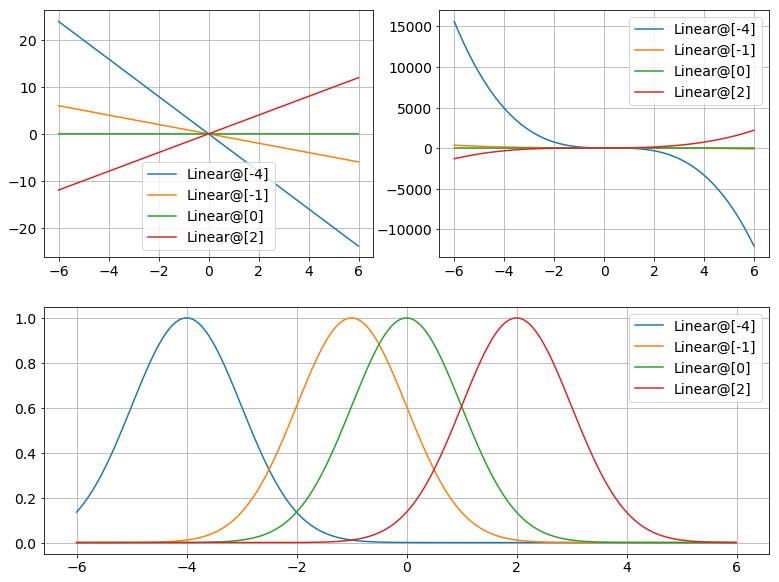

In [27]:
# PLot kernel machine functions

plot_step = .01
xpts = np.arange(-6.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# Linear kernel
plt.subplot(221)
y = linear_kernel(prototypes, xpts) 
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.grid(True)

# Polynomial kernel
plt.subplot(222)
y = polynomial_kernel(prototypes, xpts,1,3) 
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.grid(True)

# RBF kernel
plt.subplot(212)
y = RBF_kernel(prototypes, xpts,1) 
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.grid(True)

plt.show()

In [28]:
class Kernel_Machine(object):
    def __init__(self, kernel, prototype_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            prototype_points - an Rxd matrix with rows mu_1,...,mu_R
            weights - a vector of length R with entries w_1,...,w_R
        """

        self.kernel = kernel
        self.prototype_points = prototype_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R w_i k(x_j, mu_i)
        """
        K = self.kernel(X, self.prototype_points)
        
        return K.dot(self.weights)

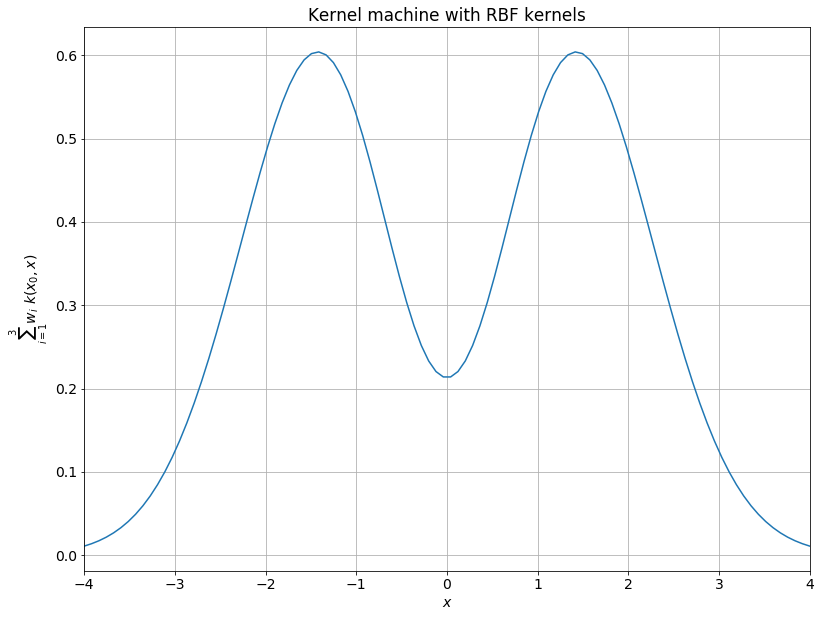

In [29]:
weights = np.array([1,-1,1]).reshape(-1,1)
prototype_points = np.array([-1, 0, 1]).reshape(-1,1)
predictor = Kernel_Machine(functools.partial(RBF_kernel, sigma=1), prototype_points, weights)

xmin = -4
xmax = 4

xpts = np.linspace(xmin, xmax,100).reshape(-1,1)
ypts = predictor.predict(xpts)

plt.plot(xpts, ypts, label=label);
plt.xlim([xmin, xmax]);
plt.grid(True);
plt.title('Kernel machine with RBF kernels');
plt.xlabel(r'$x$');
plt.ylabel(r'$\sum_{i=1}^3 w_i\ k(x_0, x)$', fontsize=14);

Load train & test data; Convert to column vectors so it generalizes well to data in higher dimensions.

In [30]:
data_train = np.loadtxt(os.path.join('..', 'data', 'krr-train.txt'))
data_test = np.loadtxt(os.path.join('..', 'data', 'krr-test.txt'))
x_train, y_train = data_train[:,0].reshape(-1,1),data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1),data_test[:,1].reshape(-1,1)

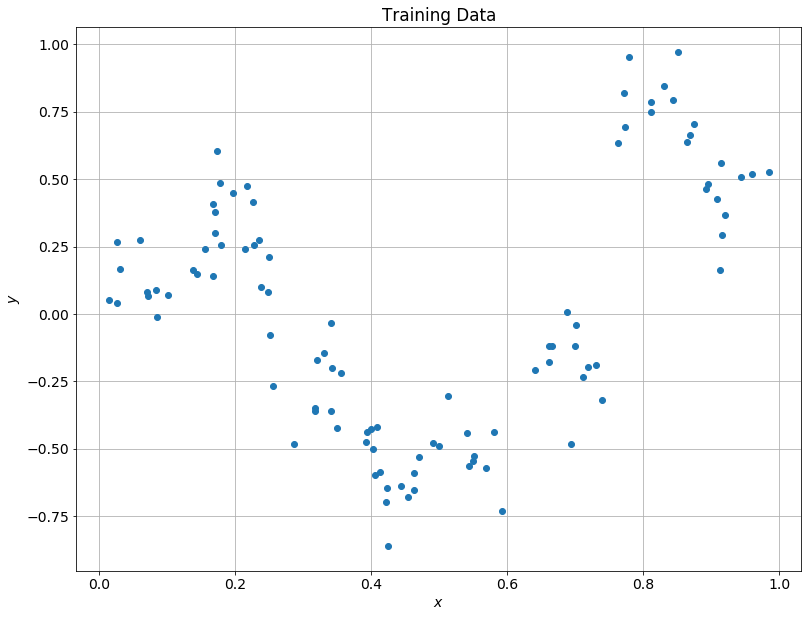

In [31]:
plt.title('Training Data');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.grid(True)

plt.plot(x_train, y_train,'o');

In [32]:
def train_kernel_ridge_regression(X, y, kernel, l2reg):
    n, _ = X.shape
    K = kernel(X, X)
    alpha = np.linalg.lstsq(K + l2reg*np.eye(n), y, rcond=-1)[0]

    return Kernel_Machine(kernel, X, alpha)

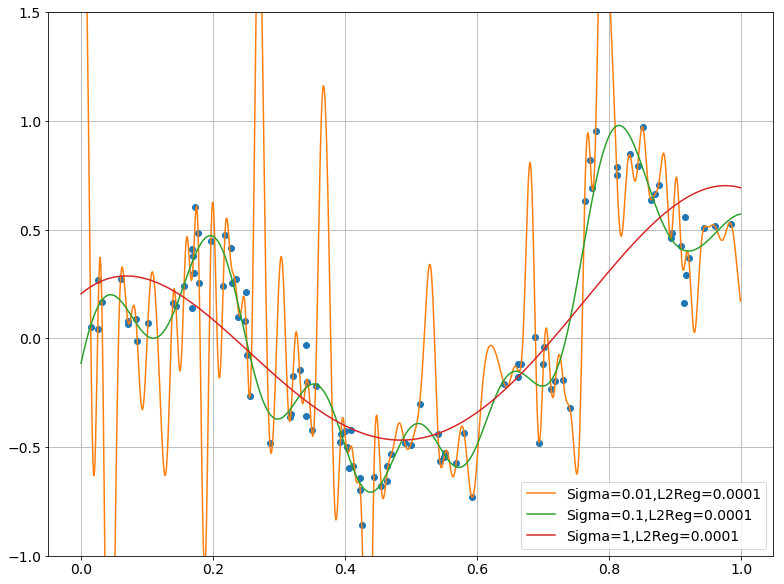

In [33]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
l2reg = 0.0001

for sigma in [.01,.1,1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
    
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

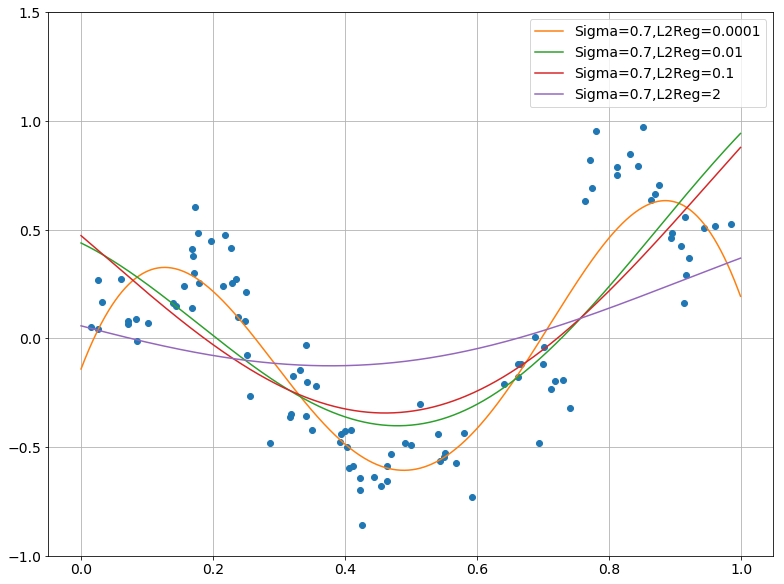

In [35]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
sigma= 0.7
for l2reg in [.0001,.01,.1,2]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

In [36]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class KernelRidgeRegression(BaseEstimator, RegressorMixin):  
    """sklearn wrapper for our kernel ridge regression"""
     
    def __init__(self, kernel="RBF", sigma=1, degree=2, offset=1, l2reg=1):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg 

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_kernel_ridge_regression(X, y, self.k, self.l2reg)

        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))

    def score(self, X, y=None):
        # get the average square error
        return(((self.predict(X)-y)**2).mean()) 

In [ ]:
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
import pandas as pd
    
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [ ]:
param_grid = [{'kernel': ['RBF'],'sigma':[.1,1,10], 'l2reg': np.exp2(-np.arange(-5,5,1))},
              {'kernel':['polynomial'],'offset':[-1,0,1], 'degree':[2,3,4],'l2reg':[10, .1, .01] },
              {'kernel':['linear'],'l2reg': [10,1,.01]}]
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False)
                  # n_jobs = -1  #should allow parallelism, but crashes Python on my machine
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

In [ ]:
pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])

In [ ]:
# Can be a more convenient way to look at the table
import qgrid 
#qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to your /nbextensions folderd_toshow = df[show].fillna('-')
qgrid.show_grid(df_toshow)

In [ ]:
## Plot the best polynomial and RBF fits you found
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
#Plot best polynomial fit
offset= 1
degree = 1
l2reg = 1
k = functools.partial(polynomial_kernel, offset=offset, degree=degree)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Offset="+str(offset)+",Degree="+str(degree)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
#Plot best RBF fit
sigma = 1
l2reg= 1
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.75)
plt.show()

In [ ]:
# Load and plot the SVM data
#load the training and test sets
data_train,data_test = np.loadtxt("svm-train.txt"),np.loadtxt("svm-test.txt")
x_train, y_train = data_train[:,0:2], data_train[:,2].reshape(-1,1)
x_test, y_test = data_test[:,0:2], data_test[:,2].reshape(-1,1)

#determine predictions for the training set
yplus = np.ma.masked_where(y_train[:,0]<=0, y_train[:,0])
xplus = x_train[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_train[:,0]>0, y_train[:,0])
xminus = x_train[~np.array(yminus.mask)]

#plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='r', label = '+1 labels for training set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 labels for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

In [ ]:
# Code to help plot the decision regions
# (Note: This ode isn't necessarily entirely appropriate for the questions asked. So think about what you are doing.)
 
sigma=1
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_soft_svm(x_train, y_train, k, ...)

#determine the decision regions for the predictions
x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

Z = f.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = f.predict (x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 
decision =ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b', label = '+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with RBF Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

# Appendix A

If $\Sigma \succeq 0$ with eigenvector $v$ with eigenvalue $\sigma$ then 
$$
\begin{align*}
v^T\Sigma v &\ge 0 \qquad //\text{definition of PSD} \\
v^T (\sigma v) &\ge 0 \\
\sigma ||v||^2 &\ge 0\\
\sigma &\ge 0
\end{align*}
$$

This shows that any eigenvector of a PSD matrix will be nonnegative

If $\Sigma \succeq 0 \implies \Sigma = BB^T$. This follows from the fact that a symmetric matrix has eigenvalue decomposition $\Sigma = Q\mathbf{diag}(\sigma_1, \sigma_2, \ldots, \sigma_n)Q^T$. Since all the eigenvalues are nonnegative we have $\Sigma = QD^{1/2}D^{T/2}Q^T$ where $D^{1/2} = \mathbf{diag}\left(\sqrt{\sigma_1}, \sqrt{\sigma_2}, \ldots, \sqrt{\sigma_n}\right)$. We can identify $B= QD^{1/2}$

If $\Sigma = BB^T \implies \Sigma\succeq 0$. This follows immediately from the definition of PSD

$$
\begin{align*}
x^T\Sigma x &= x^TBB^Tx\\
  &= (Bx)^TB^Tx\\
  &= ||Bx||^2 \qquad //\ x^Tx = ||x||^2\\
  &\ge 0
\end{align*}
$$

Therefore $\Sigma \succeq 0$ if and only if it has a square root.

# Appendix B

If $\Sigma \succ 0$ with eigenvector $v$ and eigenvalue $\sigma$ the 
$$
\begin{align*}
    v^T\Sigma v > 0  \qquad //\ \text{def of positive definite}\\
    v^T(\sigma v) > 0\\
    \sigma||v||^2 > 0\\
    \sigma > 0
\end{align*}
$$

By the spectral theorem we can write $\Sigma = QDQ^T$ where $Q^TQ = I$ and $D = \mathbf{diag}(\sigma_1,\sigma_2,\ldots,\sigma_n)$. We can trivially verify that $QD^{-1}Q^T$ is the inverse of $\Sigma$ since 

$$
\begin{align*}
    (QD^{-1}Q^T)\Sigma &= (QD^{-1}Q^T)QDQ^T \\
    &= QD^{-1}DQ^T\\
    &=QQ^T\\
    &= I \qquad \blacksquare
\end{align*}
$$

If $M \succeq 0$ and $\lambda > 0$ then $M+\lambda I \succ 0$.

$$
\begin{align*}
  x^T(M+\lambda I)x &= x^TMx +\lambda ||x||^2\\
  &\ge \lambda ||x||^2 \\
  & > 0      \qquad \forall x \ne 0
\end{align*}
$$

If $M \succeq 0$ and $N\succ 0$ then $M+N \succ 0$ which follows immediately form the definition

$$
\begin{align*}
    x^T(M+N)x &= x^TMx + x^TNx\\
    &\ge x^TNx\\
    &> 0 \qquad \forall x \ne 0
\end{align*}
$$